# RNN II

Pytorch Example:Classifying Names with a Character-Level RNN   https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

How can we use the RNN technology to classify lastnames by nationality?

Let's consider the word 'Dolores', our program will read letter by letter and make a classification based on the previous subwords:
> D

(-2.13) Korean
(-2.47) Vietnamese
(-2.52) English

> Do

(-0.44) Vietnamese
(-2.51) Korean
(-2.87) Portuguese

> Dol

(-1.21) Vietnamese
(-1.69) Korean
(-1.73) Chinese

> Dolo

(-1.22) Spanish
(-1.27) Italian
(-2.17) Portuguese

> Dolor

(-1.45) French
(-1.69) German
(-1.76) English

> Dolore

(-0.80) French
(-2.28) Italian
(-2.45) Irish

> Dolores

(-0.33) Portuguese
(-1.76) Spanish
(-3.56) Greek

Our program has the following architecture.

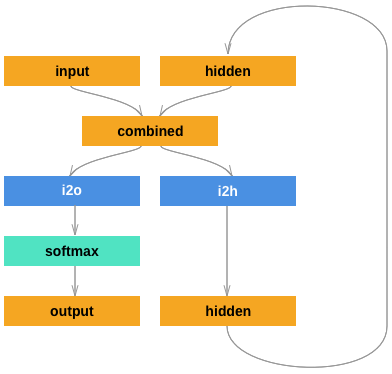

In [38]:
from IPython.display import Image
Image("nn.png")

In [22]:
import torch.nn as nn #How does the diagram translates into code?

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        hidden_units = 200
        
        self.relu = nn.ReLU()
        
        self.Linear11 = nn.Linear(input_size + hidden_size,hidden_units)
        self.Linear12 = nn.Linear(hidden_units,hidden_size)
        
        self.Linear21 = nn.Linear(input_size+hidden_size,hidden_units)
        self.Linear22 = nn.Linear(hidden_units,output_size)

        #self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        #self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.relu(self.Linear12(self.relu(self.Linear11(combined))))
        output = self.relu(self.Linear22(self.relu(self.Linear21(combined))))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Here we can test our program:

In [17]:
predict('Gonzalez')

NameError: name 'predict' is not defined

The code is at the end of the notebook.

## Other variants:
### Peephole connections
The gate controllers can look at the long-term state as well (Felix Gers and Jurgen Schmidhuber, 2000).

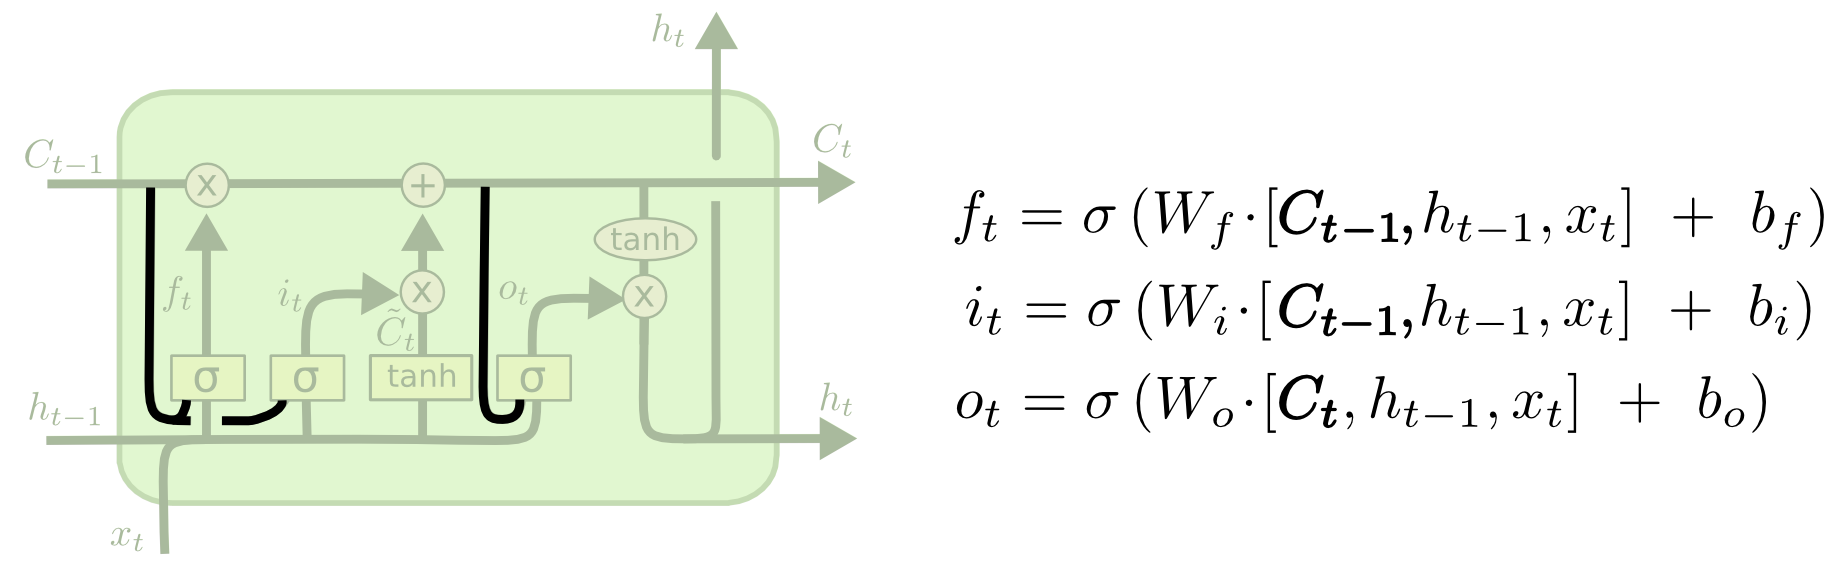

In [18]:
from IPython.display import Image
Image("peepholes.png")

## Tied 
Coupled forget and input gates. 

If the gate controller inputs a 1, the forget gate is open and the input gate is closed. 

If the gate controller inputs a 0, the forget gate is closed and the input gate is open. 

Whenever a memory must be stored, the location where it will be stored is erased first.

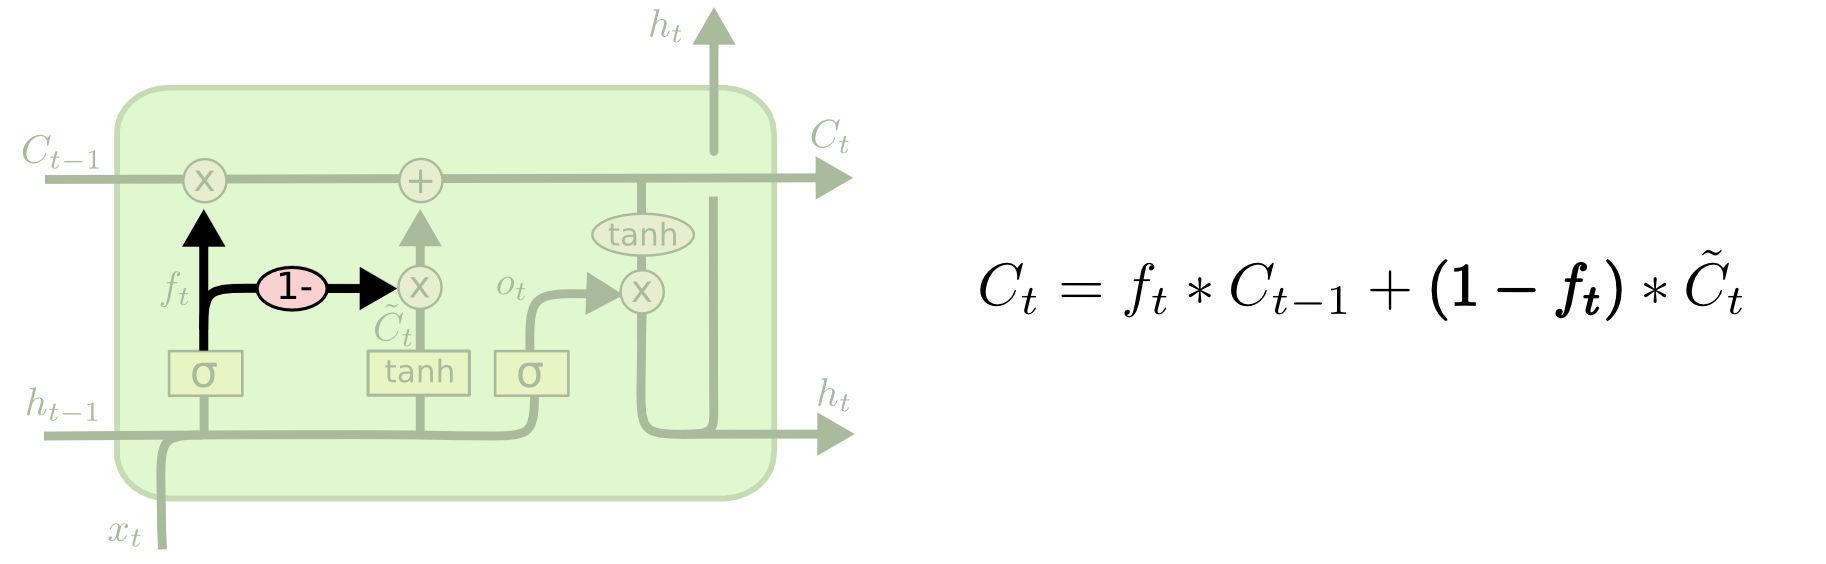

In [19]:
from IPython.display import Image
Image("tied.png")

## GRU
Gated Recurrent Unit (Kyunghyun Cho, 2014).
Both state vectors are merged into a single vector $h_t$.

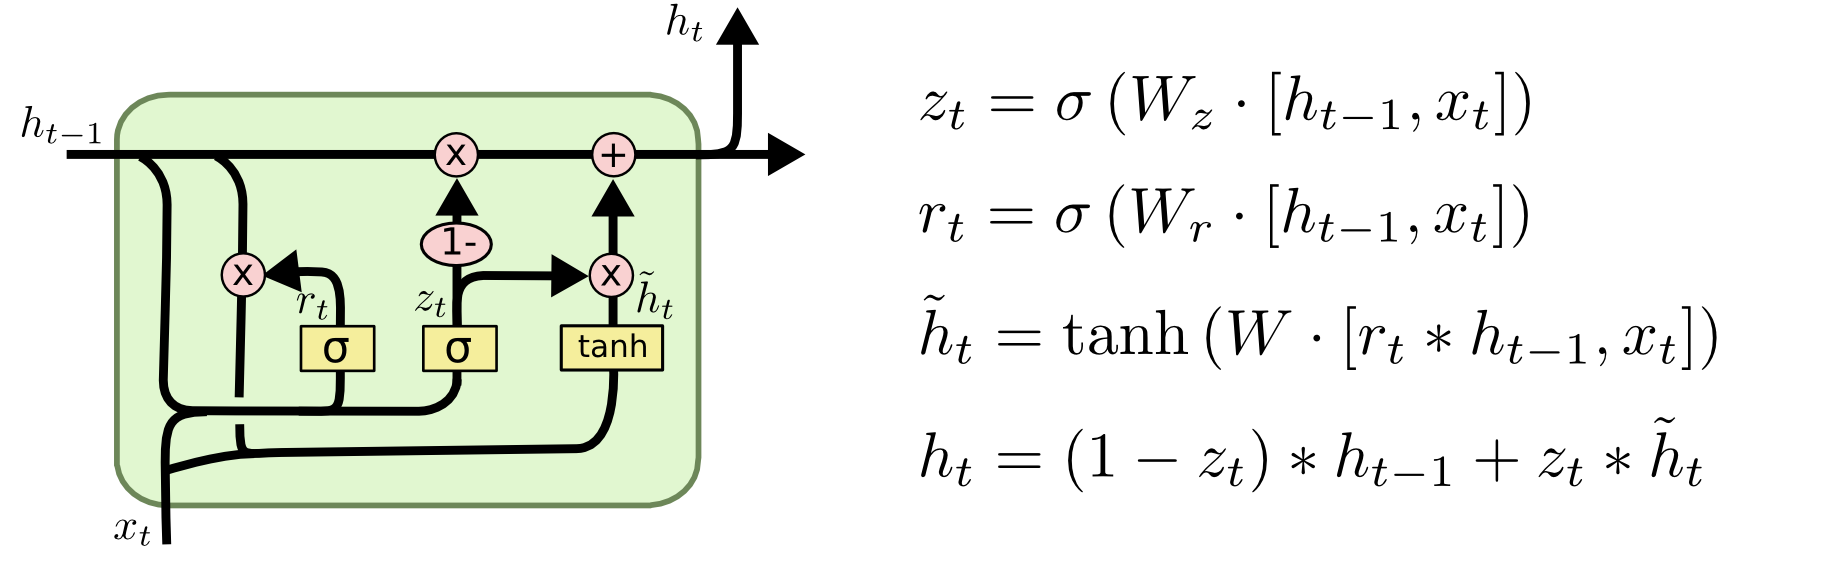

In [20]:
from IPython.display import Image
Image("GRU.png")

## Loading data

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


## Line to tensor

In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('e'))

print(lineToTensor('Eric').size())

tensor([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([4, 1, 57])


## Definition of the NN

In [3]:

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128


rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)


In [24]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9117, -2.8762, -2.8341, -2.9107, -2.9117, -2.9117, -2.9117,
         -2.8690, -2.8462, -2.8959, -2.8815, -2.8350, -2.8845, -2.9117,
         -2.9066, -2.9117, -2.9117, -2.9117]])


## Output edition 

In [25]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 2)


In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Yeo
category = French / line = Charron
category = Chinese / line = Liang
category = Polish / line = Zdunowski
category = English / line = Dowson
category = Scottish / line = Alexander
category = Irish / line = Fearghal
category = German / line = Kneib
category = Japanese / line = Ikina
category = English / line = Oakey


In [27]:
criterion = nn.NLLLoss() #We use negative loss likelihood for classification problems

## Training 

In [28]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 28s) 2.9367 So / Italian ✗ (Korean)
10000 10% (0m 55s) 2.7307 Ould / Chinese ✗ (English)
15000 15% (1m 22s) 3.3174 Cernohous / Greek ✗ (Czech)
20000 20% (1m 49s) 2.4407 Roosevelt / English ✗ (Dutch)
25000 25% (2m 16s) 0.7299 Szczepanski / Polish ✓
30000 30% (2m 43s) 2.2319 Najjar / Arabic ✓
35000 35% (3m 11s) 2.1505 Ashby / Irish ✗ (English)
40000 40% (3m 37s) 1.4241 Bueren / Dutch ✓
45000 45% (4m 4s) 3.4230 Christie / Russian ✗ (Scottish)
50000 50% (4m 32s) 1.3568 Pasternack / Czech ✗ (Polish)
55000 55% (4m 59s) 0.8003 Daalen / Dutch ✓
60000 60% (5m 27s) 0.6551 Abdrazakoff / Russian ✓
65000 65% (5m 54s) 1.5666 Russo / Italian ✓
70000 70% (6m 22s) 2.4588 Lennon / English ✗ (Irish)
75000 75% (6m 53s) 3.1681 Coelho / Italian ✗ (Portuguese)
80000 80% (7m 21s) 2.8714 O'Loughlin / Russian ✗ (Irish)
85000 85% (7m 48s) 0.0751 Avgerinos / Greek ✓
90000 90% (8m 14s) 3.2985 Trinh / Irish ✗ (Vietnamese)
95000 95% (8m 42s) 1.5784 Mustafa / Arabic ✓
100000 100% (9m 9s) 0.0271 Shon / Kor

## Plotting 

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

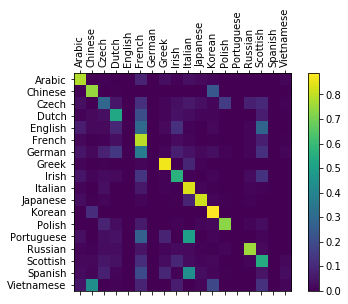

In [31]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [32]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.14) Russian
(-2.54) Czech
(-3.89) Scottish

> Jackson
(-0.21) Scottish
(-2.84) English
(-3.99) Russian

> Satoshi
(-0.14) Japanese
(-2.30) Arabic
(-4.63) Polish


In [54]:
predict('Roland')


> Roland
(-1.17) French
(-1.18) Scottish
(-2.25) English
